# FSSC Fermitools 

=========================`

*Fermi LAT Likelihood Analysis using Python (2021 edition)

*Nestor Mirabal (NASA GSFC), Jeremy Perkins (NASA GSFC)
-------------------------

**Goal:** *Understand and Complete a simple likelihood analysis using the Fermitools in python*

On Week 1 we learned...
==========================
* How to download LAT data
* How to filter LAT data using gtselect and gtmktime

We are going to use the same PH00.fits, PH01.fits and SC00.fits from [Week 1](https://github.com/FermiSummerSchool/2021_FermiSummerSchool/blob/main/Data_Exploration/Data_Exploration.ipynb). These files should be already stored in the data/ subdirectory in the shared directory where you initialized Docker. Please go ahead and create a new directory in your shared directory called binnedanalysis/. Then copy this notebook Likelihood_Analysis.ipynb and the 3C279_input_model.xml file into the new directory  

> mkdir binnedanalysis

Run the start and attach commands in your shared directory followed by conda activate and notebook to start your browser

(base)>docker start be68136958ad

(base)>docker attach be68136958ad

>cd /data/binnedanalysis

>conda activate fermi

(fermi)>notebook

We are going to filter the data just like we did in Week 1.

In [1]:
from gt_apps import filter

In [2]:
filter['infile'] = '@../data/events.txt'
filter['outfile'] = '../data/3C279_filtered.fits'
filter['ra'] = 194.05
filter['dec'] = -5.79
filter['rad'] = 15
filter['tmin'] = 239557417
filter['tmax'] = 255398400
filter['emin'] = 100
filter['emax'] = 500000
filter['zmax'] = 90
filter['evclass'] = 128
filter['evtype'] = 3

In [3]:
filter.run()

time -p gtselect infile=@../data/events.txt outfile=../data/3C279_filtered.fits ra=194.05 dec=-5.79 rad=15.0 tmin=239557417.0 tmax=255398400.0 emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 15.06
user 1.89
sys 0.95


In [4]:
from gt_apps import maketime
maketime['evfile'] = '../data/3C279_filtered.fits'
maketime['outfile'] = '../data/3C279_mktime.fits'
maketime['scfile'] = '../data/SC00.fits'
maketime['filter'] = 'DATA_QUAL>0 && LAT_CONFIG==1'
maketime['apply_filter'] = 'yes'
maketime['roicut'] = 'no'
maketime.run()

time -p gtmktime scfile=../data/SC00.fits sctable="SC_DATA" filter="DATA_QUAL>0 && LAT_CONFIG==1" roicut=no evfile=../data/3C279_filtered.fits evtable="EVENTS" outfile="../data/3C279_mktime.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 5.37
user 0.97
sys 0.35


Now, we want to keep building the elements we need to run the LAT likelihood analysis

### gtbin (or evtbin)

* Used to make counts maps (pictures) or bin the data in time and/or energy.
* First, we're going to use it to look at our Region of Interest (ROI).

In [58]:
%matplotlib inline

In [59]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits

In [50]:
from gt_apps import evtbin

In [23]:
evtbin['evfile'] = '../data/3C279_mktime.fits'
evtbin['outfile'] = '../data/3C279_cmap.fits'
evtbin['algorithm'] = 'cmap'
evtbin['nxpix'] = 150
evtbin['nypix'] = 150
evtbin['binsz'] = 0.2
evtbin['coordsys'] = 'CEL'
evtbin['xref'] = 194.05
evtbin['yref'] = -5.79
evtbin['axisrot'] = 0.0
evtbin['proj'] = 'AIT'

In [9]:
evtbin.run()

time -p gtbin evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_cmap.fits algorithm="cmap" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=150 nypix=150 binsz=0.2 coordsys="CEL" xref=194.05 yref=-5.79 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.58
user 0.30
sys 0.06


In [60]:
cmap_hdu = pyfits.open('../data/3C279_cmap.fits')

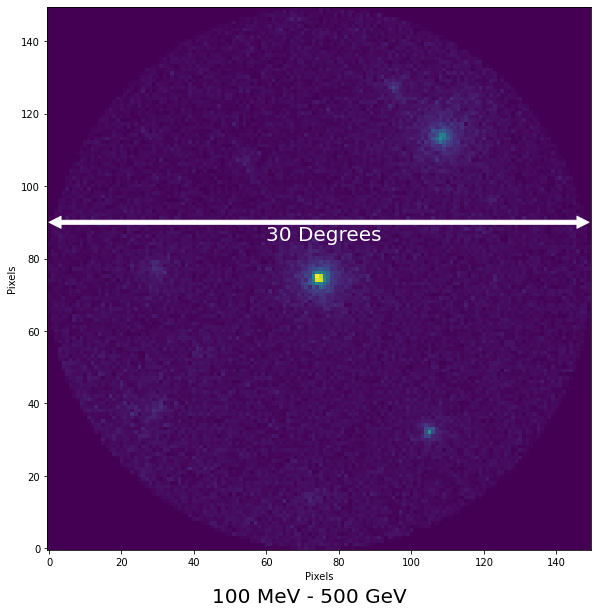

In [61]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(cmap_hdu[0].data,origin='lower')
plt.annotate(
    '', xy=(0, 90), xycoords = 'data',
    xytext = (40, 90), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.annotate(
    '', xy=(149, 90), xycoords = 'data',
    xytext = (40, 90), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.text(60, 85, '30 Degrees',fontsize=20,color='white')
plt.text(45,-15,"100 MeV - 500 GeV",fontsize=20)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

Create a binned counts cube from your data
====================================
 * Calculate the counts cube (counts map binned in energy) 
 * This is useful to see how our ROI changes with energy
 * (We'll also need this later in the analysis)
 * Notice that we used 'cmap' before and now we're using 'ccube'. Here, Number of bins ~ 10*[log(emax) - log(emin)]

In [26]:
evtbin['algorithm'] = 'CCUBE'
evtbin['evfile'] = '../data/3C279_mktime.fits'
evtbin['outfile'] = '../data/3C279_ccube.fits'
evtbin['nxpix'] = 100
evtbin['nypix'] = 100
evtbin['binsz'] = 0.2
evtbin['coordsys'] = 'CEL'
evtbin['xref'] = 194.05
evtbin['yref'] = -5.79
evtbin['axisrot'] = 0.0
evtbin['proj'] = 'AIT'
evtbin['ebinalg'] = 'LOG'
evtbin['emin'] = 100
evtbin['emax'] = 500000
evtbin['enumbins'] = 37

In [13]:
evtbin.run()

time -p gtbin evfile=../data/3C279_mktime.fits scfile=NONE outfile=../data/3C279_ccube.fits algorithm="CCUBE" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=100 nypix=100 binsz=0.2 coordsys="CEL" xref=194.05 yref=-5.79 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 3.04
user 0.36
sys 0.17


In [62]:
ccube_hdu = pyfits.open('../data/3C279_ccube.fits')

In [63]:
ccube_hdu.info()

Filename: ../data/3C279_ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     135   (100, 100, 37)   int32   
  1  EBOUNDS       1 BinTableHDU     43   37R x 3C   [I, 1E, 1E]   
  2  GTI           1 BinTableHDU     49   2791R x 2C   [D, D]   


In [64]:
import time
from IPython.display import display,clear_output

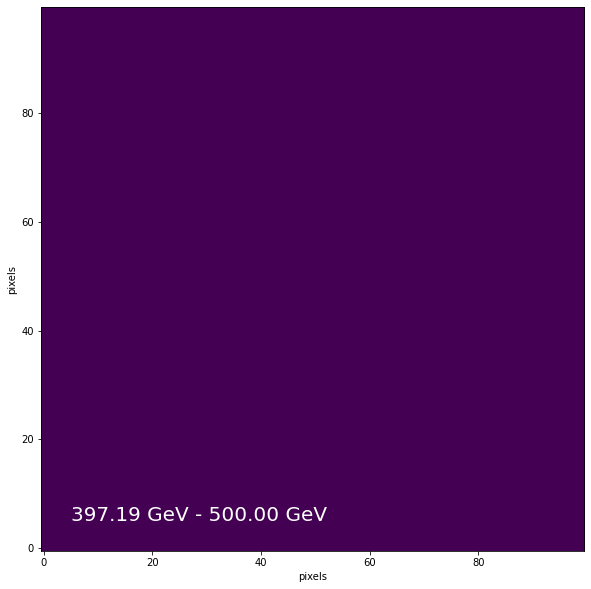

In [66]:
f, ax = plt.subplots(figsize=(10, 10))
for i, ccube in enumerate(ccube_hdu[0].data):
    time.sleep(0.2)
    plt.imshow(ccube,origin='lower')
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    label =  "{:.2f} GeV - {:.2f} GeV".format(ccube_hdu[1].data['E_MIN'][i]/1e6,
                                             ccube_hdu[1].data['E_MAX'][i]/1e6)
    plt.text(5,5,label,fontsize=20, color='white')
    clear_output(wait=True)
    display(f)
    ax.cla()
    
plt.close()

* You will see that the counts cube we just created is made up of 37 images
* ... as we are interested in spatial and energy dependence of sources
* ... best sensitivity achieved by using all information possible (as long as it can be modeled accurately!)

At higher energies there are fewer photon,
    1. Sources look less spread out (narrower PSF),
    2. There is less background.
At lower energies there are lots of photons,
    1. Sources look more spread out (broader PSF) and are more confused
    2. There is a lot of background!
Sources are most clearly detectable somewhere in the middle.

Calculating Livetime and Exposure Cubes
---------------------------------
* Calculating the exposure is a two-step process
    * **Livetime:** formally the time when the detector is available to collect data
        * For analysis, we additionally require good data quality and select to remove high background
        * The LAT has a large FoV with varying response: need to know when and where
    * **Exposure:** for practical purposes, the number that converts counts to photon flux
        * Apply expected photon detection efficiency and angular resolution
            * Depends on the event selection
            * Depends on the direction of the photon relative to the instrument boresight and energy

In [31]:
from gt_apps import expCube

In [32]:
expCube.pars()

' evfile="../data/3C279_mktime.fits" evtable="EVENTS" scfile=../data/SC00.fits sctable="SC_DATA" outfile=../data/3C279_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [20]:
expCube['evfile'] = '../data/3C279_mktime.fits'
expCube['scfile'] = '../data/SC00.fits'
expCube['outfile'] = '../data/3C279_ltcube.fits'
expCube['dcostheta'] = 0.025
expCube['binsz'] = 1.0
expCube['zmax'] = 90

In [21]:
expCube.run()

time -p gtltcube evfile="../data/3C279_mktime.fits" evtable="EVENTS" scfile=../data/SC00.fits sctable="SC_DATA" outfile=../data/3C279_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=90.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file ../data/SC00.fits
.....................!
real 714.04
user 663.26
sys 4.09


This takes a while to run...


### Calculate the Exposure

Now we need to apply the livetime calculated in the previous step to your region of interest. To do this we use the gtexpcube2 tool.

In [33]:
from gt_apps import gtexpcube2
gtexpcube2['infile'] = '../data/3C279_ltcube.fits'
gtexpcube2['cmap'] = '../data/3C279_ccube.fits'
gtexpcube2['outfile'] = '../data/3C279_expcube.fits'
gtexpcube2['nxpix'] = 300
gtexpcube2['nypix'] = 300
gtexpcube2['binsz'] = 0.2
gtexpcube2['coordsys'] = 'CEL'
gtexpcube2['xref'] = 194.05
gtexpcube2['yref'] = -5.79
gtexpcube2['axisrot'] = 0.0
gtexpcube2['proj'] = 'AIT'
gtexpcube2['ebinalg'] = 'LOG'
gtexpcube2['emin'] = 100
gtexpcube2['emax'] = 500000
gtexpcube2['enumbins'] = 37
gtexpcube2['irfs'] = 'P8R3_SOURCE_V3'

In [23]:
ls ../data

3C279_ccube.fits     3C279_input_model.xml  events.txt   PH01.fits
3C279_cmap.fits      3C279_ltcube.fits      events.txt~  SC00.fits
3C279_filtered.fits  3C279_mktime.fits      PH00.fits


In [24]:
gtexpcube2.run()

time -p gtexpcube2 infile=../data/3C279_ltcube.fits cmap=../data/3C279_ccube.fits outfile=../data/3C279_expcube.fits irfs="P8R3_SOURCE_V3" evtype="INDEF" edisp_bins=0 nxpix=300 nypix=300 binsz=0.2 coordsys="CEL" xref=194.05 yref=-5.79 axisrot=0.0 proj="AIT" ebinalg="LOG" emin=100.0 emax=500000.0 enumbins=37 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"
Computing binned exposure map....................!
real 39.42
user 14.15
sys 1.57


Model for our Sample ROI
===============================

* Point Sources: $$S(E,\hat{p},t) = \sum_i s_i(E,t)\delta(\hat{p}-\hat{p}_i)$$
* Galactic Diffuse: $$+ S_G(E,\hat{p})$$ 
* Extragalactic and Residual: $$+ S_{eg}(E,\hat{p})$$ 
* Other Extended Sources (Optional): $$+ \sum_l S_l(E,\hat{p},t)$$ 

Example for a power law spectral model
---------------------------------

$$S(E,\hat{p},t) = S(E,F_0,\Gamma,E_0) = F_0(\frac{E}{E_0})^{-\Gamma}$$


We now have everyhitng we need to perform the maximum likelihood optimization.  We have the photons, we have the exposure but we don't have a model.  We'll talk about how to build this model in a bit but for now, I'm giving you a sample model definition for the purposes of this analysis.  Here's what the file looks like:

    <?xml version="1.0" ?>
    <source_library title="source library" xmlns="http://fermi.gsfc.nasa.gov/source_library">

    <source name="iso_P8R3_SOURCE_V3_v1" type="DiffuseSource">
        <spectrum applyfile="$(CONDA_PREFIX)/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt" type="FileFunction">
            <parameter free="1" max="1000" min="1e-05" name="Normalization" scale="1" value="1" />
        </spectrum>
        <spatialModel type="ConstantValue">
            <parameter free="0" max="10.0" min="0.0" name="Value" scale="1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="gll_iem_v07.fits" type="DiffuseSource">
        <spectrum type="PowerLaw">
          <parameter free="0" max="1.0" min="-1.0" name="Index" scale="-1.0" value="0.0"/>
          <parameter free="0" max="1000.0" min="1000.0" name="Scale" scale="1.0" value="1000.0"/>
          <parameter free="0" max="10.0" min="0.1" name="Prefactor" scale="1.0" value="1.0"/>
        </spectrum>
        <spatialModel file="$(CONDA_PREFIX)/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits" type="MapCubeFunction">
            <parameter free="0" max="1000.0" min="0.001" name="Normalization" scale= "1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="3C 273" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="187.25"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="2.17"/>
        </spatialModel>
    </source>

    <source name="3C 279" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="193.98"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-5.82"/>
        </spatialModel>
    </source>

    </source_library>

The model file is stored in a format called eXtensible Markup Language (XML) which is just a set of rules to encode information in a text file.  The model file is our description of what we think the region should look like.  You'll hear more about how to create these files later. This file is 3C_279_input_model.xml which should be in your current directory

Notice that the model file makes refernce to two files, [iso_P8R3_SOURCE_V3_v1.txt](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html) and [gll_iem_v07](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html).  These two files describe the extragalactic and galactic diffuse emission respectively. They are included in the conda distribution and are in `$CONDA_PREFIX/share/fermitools/refdata/fermi/galdiffuse`.

In [25]:
ls $CONDA_PREFIX/share/fermitools/refdata/fermi/galdiffuse

EGRET_diffuse_cel.fits*
EGRET_diffuse_gal.fits*
gll_iem_v07.fits*
GP_gamma.fits*
GP_gamma_v0r0p1.fits*
iso_clean_back_v05_rev1.txt*
iso_clean_front_v05_rev1.txt*
iso_clean_v05_rev1.txt*
iso_clean_v05.txt*
iso_p7v6clean.txt*
iso_p7v6source.txt*
iso_P8R2_CLEAN_V6_BACK_v06.txt*
iso_P8R2_CLEAN_V6_EDISP0_v06.txt*
iso_P8R2_CLEAN_V6_EDISP1_v06.txt*
iso_P8R2_CLEAN_V6_EDISP2_v06.txt*
iso_P8R2_CLEAN_V6_EDISP3_v06.txt*
iso_P8R2_CLEAN_V6_FRONT_v06.txt*
iso_P8R2_CLEAN_V6_PSF0_v06.txt*
iso_P8R2_CLEAN_V6_PSF1_v06.txt*
iso_P8R2_CLEAN_V6_PSF2_v06.txt*
iso_P8R2_CLEAN_V6_PSF3_v06.txt*
iso_P8R2_CLEAN_V6_v06.txt*
iso_P8R2_SOURCE_V6_BACK_v06.txt*
iso_P8R2_SOURCE_V6_EDISP0_v06.txt*
iso_P8R2_SOURCE_V6_EDISP1_v06.txt*
iso_P8R2_SOURCE_V6_EDISP2_v06.txt*
iso_P8R2_SOURCE_V6_EDISP3_v06.txt*
iso_P8R2_SOURCE_V6_FRONT_v06.txt*
iso_P8R2_SOURCE_V6_PSF0_v06.txt*
iso_P8R2_SOURCE_V6_PSF1_v06.txt*
iso_P8R2_SOURCE_V6_PSF2_v06.txt*
iso_P8R2_SOURCE_V6_PSF3_v06.txt*
iso_P8R2_SOURCE_V6_v06.txt*
iso_P8R2_TRANSIENT010E_V6_BACK_v0

iso_P8R3_TRANSIENT015S_V2_EDISP2_v1.txt*
iso_P8R3_TRANSIENT015S_V2_EDISP3_v1.txt*
iso_P8R3_TRANSIENT015S_V2_FRONT_v1.txt*
iso_P8R3_TRANSIENT015S_V2_PSF0_v1.txt*
iso_P8R3_TRANSIENT015S_V2_PSF1_v1.txt*
iso_P8R3_TRANSIENT015S_V2_PSF2_v1.txt*
iso_P8R3_TRANSIENT015S_V2_PSF3_v1.txt*
iso_P8R3_TRANSIENT015S_V2.txt*
iso_P8R3_TRANSIENT015S_V2_v1.txt*
iso_P8R3_TRANSIENT015S_V3_BACK_v1.txt*
iso_P8R3_TRANSIENT015S_V3_EDISP0_v1.txt*
iso_P8R3_TRANSIENT015S_V3_EDISP1_v1.txt*
iso_P8R3_TRANSIENT015S_V3_EDISP2_v1.txt*
iso_P8R3_TRANSIENT015S_V3_EDISP3_v1.txt*
iso_P8R3_TRANSIENT015S_V3_FRONT_v1.txt*
iso_P8R3_TRANSIENT015S_V3_PSF0_v1.txt*
iso_P8R3_TRANSIENT015S_V3_PSF1_v1.txt*
iso_P8R3_TRANSIENT015S_V3_PSF2_v1.txt*
iso_P8R3_TRANSIENT015S_V3_PSF3_v1.txt*
iso_P8R3_TRANSIENT015S_V3_v1.txt*
iso_P8R3_TRANSIENT020_BACK_V2.txt*
iso_P8R3_TRANSIENT020E_BACK_V2.txt*
iso_P8R3_TRANSIENT020_EDISP0_V2.txt*
iso_P8R3_TRANSIENT020_EDISP1_V2.txt*
iso_P8R3_TRANSIENT020_EDISP2_V2.txt*
iso_P8R3_TRANSIENT020_EDISP3_V2.txt*
iso_P









Notice that these are suspiciously named like they might depend on the event class you're using.  You would be right to assume so.  Let's take a look at these.  The isotropic diffuse model is just a text file:

In [67]:
import numpy as np
from os import environ

In [68]:
isotropic = np.genfromtxt(environ['CONDA_PREFIX'] + 
                          "/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt")

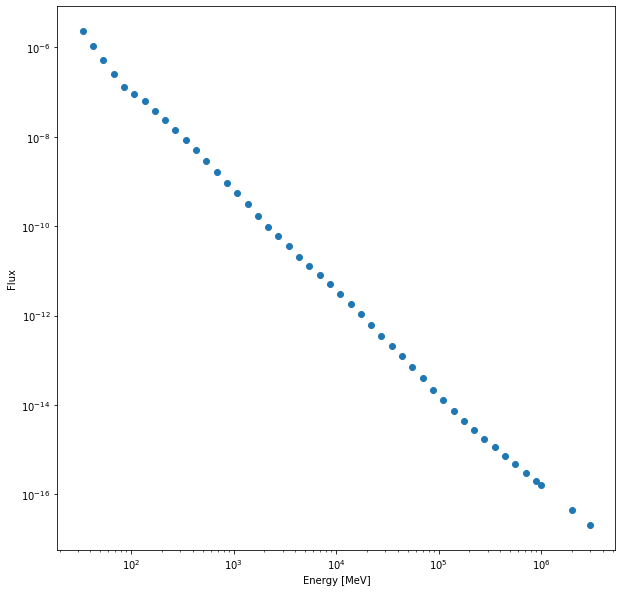

In [69]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xscale('log')
plt.plot(isotropic[:,0],isotropic[:,1], 'o')
plt.xlabel('Energy [MeV]')
plt.ylabel('Flux')
plt.show()

The isotropic model is spatially isotropic but is energy dependent.  Open up the galactic diffuse:

In [70]:
gal_diff = pyfits.open(environ['CONDA_PREFIX'] + 
                          "/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits")

In [71]:
gal_diff.info()

Filename: /opt/anaconda/envs/fermi/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (2880, 1441, 28)   float32   
  1  ENERGIES      1 BinTableHDU     12   28R x 1C   [D]   


In [72]:
from matplotlib.colors import LogNorm

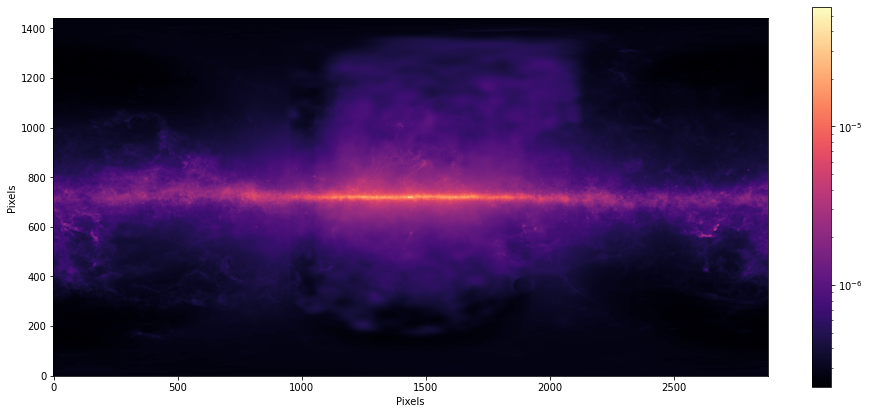

In [73]:
plt.figure(figsize=(16,7))
plt.imshow(gal_diff[0].data[0],cmap='magma',norm=LogNorm(),origin='lower')
plt.colorbar()
plt.ylabel('Pixels')
plt.xlabel('Pixels')
plt.show()

The model for the Galactic diffuse emission was developed using spectral line surveys of HI and CO (as a tracer of H2) to derive the distribution of interstellar gas in Galactocentric rings. Infrared tracers of dust column density were used to correct column densities in directions where the optical depth of HI was either over or under-estimated. The model of the diffuse gamma-ray emission was then constructed by fitting the gamma-ray emissivities of the rings in several energy bands to the LAT observations. The fitting also required a model of the inverse Compton emission calculated using GALPROP and a model for the isotropic diffuse emission. [A complete description of the Galactic diffuse model is available](http://iopscience.iop.org/article/10.3847/0067-0049/223/2/26).

## Compute the souce maps

These are model counts maps for all of the sources in our model assuming our esposure, response, and spectral models.

This takes a while so let get it going and then talk about what's next.



In [74]:
from gt_apps import srcMaps

In [16]:
srcMaps['expcube'] = '../data/3C279_ltcube.fits'
srcMaps['cmap'] = '../data/3C279_ccube.fits'
srcMaps['srcmdl'] = '3C279_input_model.xml'
srcMaps['bexpmap'] = '../data/3C279_expcube.fits'
srcMaps['outfile'] = '../data/3C279_srcmaps.fits'
srcMaps['irfs'] = 'CALDB'

In [17]:

srcMaps.run()

time -p gtsrcmaps scfile= sctable="SC_DATA" expcube=../data/3C279_ltcube.fits cmap=../data/3C279_ccube.fits srcmdl=3C279_input_model.xml bexpmap=../data/3C279_expcube.fits wmap=none outfile=../data/3C279_srcmaps.fits irfs="CALDB" evtype="INDEF" convol=yes resample=yes rfactor=2 minbinsz=0.1 ptsrc=yes psfcorr=yes emapbnds=yes edisp_bins=0 copyall=no chatter=2 clobber=yes debug=no gui=no mode="ql"
Generating SourceMap for 3C 273 38....................!
Generating SourceMap for 3C 279 38....................!
Generating SourceMap for gll_iem_v07.fits 38....................!
Generating SourceMap for iso_P8R3_SOURCE_V3_v1 38....................!
real 146.95
user 105.87
sys 7.18


Perform a Binned Likelihood fit
====================

We are ready to go now.  We are going to do this the python way (you could use *gtlike* or fermipy if you wish).

In [18]:
from BinnedAnalysis import *

First, create an observation object which describes your observation.

In [43]:
obs = BinnedObs(srcMaps='../data/3C279_srcmaps.fits',
                expCube='../data/3C279_ltcube.fits',
                binnedExpMap='../data/3C279_expcube.fits',
                irfs='CALDB')

Now, create an analysis object.

In [44]:
analysis = BinnedAnalysis(obs,srcModel='3C279_input_model.xml', optimizer='MINUIT')

Note that we selected an *optimizer*.  There are a couple of options (see the help file for gtlike) but most of the time you'll using one of the MINUIT optimizers (NEWMINUIT or MINUIT).  Now, we're ready to do the actual fit, but we can check out the objects we just created if we want.

In [45]:
likeObj = pyLike.Minuit(analysis.logLike)

In [46]:
analysis.tol

0.001

In [42]:
analysis.fit?

There are lots of other variables and functions associated with these. For now, lets do the fit.

In [61]:
analysis.fit()

96397.43935158345

We can get the quality of the fit by running

In [65]:
likeObj.getRetCode()

0

Convergence in the fit gives a return code 0. Next, we can take a look at the model 

In [45]:
analysis.model

3C 273
   Spectrum: PowerLaw
0      Prefactor:  9.297e+00  2.792e-01  1.000e-03  1.000e+03 ( 1.000e-09)
1          Index: -2.629e+00  2.226e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
2          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

3C 279
   Spectrum: PowerLaw
3      Prefactor:  7.311e+00  1.958e-01  1.000e-03  1.000e+03 ( 1.000e-09)
4          Index: -2.206e+00  1.471e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
5          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

gll_iem_v07.fits
   Spectrum: PowerLaw
6      Prefactor:  1.000e+00  0.000e+00  1.000e-01  1.000e+01 ( 1.000e+00) fixed
7          Index:  0.000e+00  0.000e+00 -1.000e+00  1.000e+00 (-1.000e+00) fixed
8          Scale:  1.000e+03  0.000e+00  1.000e+03  1.000e+03 ( 1.000e+00) fixed

iso_P8R3_SOURCE_V3_v1
   Spectrum: FileFunction
9     Normalization:  1.453e+00  1.688e-02  1.000e-05  1.000e+03 ( 1.000e+00)

In [46]:
analysis.thaw(6)
analysis.thaw(9)

In [47]:
analysis.fit()

96397.4393543629

In [48]:
analysis.model

3C 273
   Spectrum: PowerLaw
0      Prefactor:  9.747e+00  2.880e-01  1.000e-03  1.000e+03 ( 1.000e-09)
1          Index: -2.649e+00  2.219e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
2          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

3C 279
   Spectrum: PowerLaw
3      Prefactor:  7.467e+00  2.009e-01  1.000e-03  1.000e+03 ( 1.000e-09)
4          Index: -2.222e+00  1.496e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
5          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

gll_iem_v07.fits
   Spectrum: PowerLaw
6      Prefactor:  1.566e+00  4.401e-02  1.000e-01  1.000e+01 ( 1.000e+00)
7          Index:  0.000e+00  0.000e+00 -1.000e+00  1.000e+00 (-1.000e+00) fixed
8          Scale:  1.000e+03  0.000e+00  1.000e+03  1.000e+03 ( 1.000e+00) fixed

iso_P8R3_SOURCE_V3_v1
   Spectrum: FileFunction
9     Normalization:  4.579e-01  7.821e-02  1.000e-05  1.000e+03 ( 1.000e+00)

You can also get at the test statistic of a specific source

In [49]:
analysis.Ts('3C 279')

11493.445981418889

and the number of predicted counts

In [50]:
analysis.NpredValue('3C 279')

7291.463107298258

You can plot a counts spectrum (and residuals) in python:

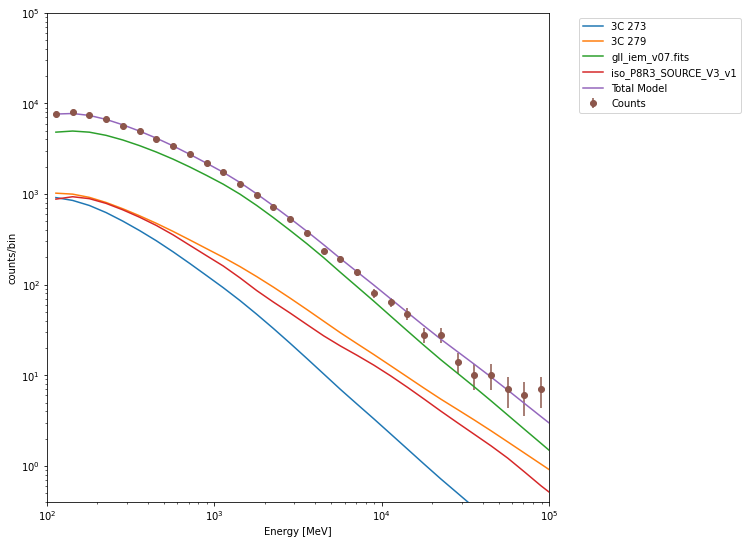

In [51]:
E = (analysis.energies[:-1] + analysis.energies[1:])/2.
#The 'energies' array are the endpoints so we take the midpoint of the bins.
plt.figure(figsize=(9,9))
plt.ylim((0.4,1e5))
plt.xlim((100,100000))
sum_model = np.zeros_like(analysis._srcCnts(analysis.sourceNames()[0]))
for sourceName in analysis.sourceNames():
    sum_model = sum_model + analysis._srcCnts(sourceName)
    plt.loglog(E,analysis._srcCnts(sourceName),label=sourceName)
plt.loglog(E,sum_model,label='Total Model')
plt.errorbar(E,analysis.nobs,yerr=np.sqrt(analysis.nobs), fmt='o',label='Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('counts/bin')
plt.xlabel('Energy [MeV]')
plt.show()

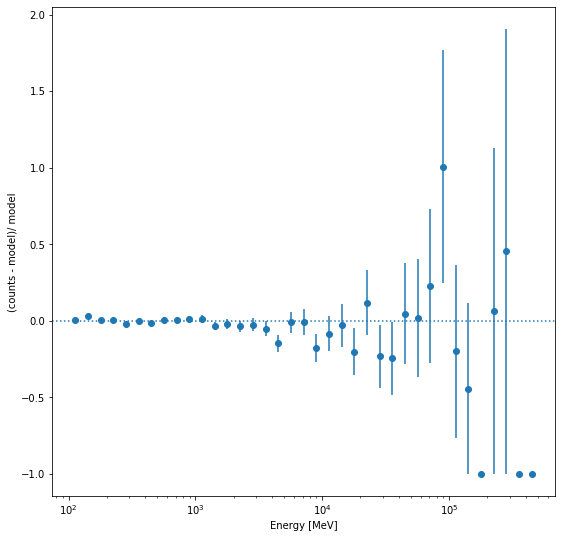

In [52]:
resid = (analysis.nobs - sum_model)/sum_model
resid_err = (np.sqrt(analysis.nobs)/sum_model)
plt.figure(figsize=(9,9))
plt.xscale('log')
plt.errorbar(E,resid,yerr=resid_err,fmt='o')
plt.axhline(0.0,ls=':')
plt.xlabel('Energy [MeV]')
plt.ylabel('(counts - model)/ model')
plt.show()

You can output a new XML model:

In [53]:
analysis.writeXml('3C279_output_model.xml')

"Binned" or "Unbinned" (or both)?
=================================
* We did a binned analysis here.
* Binned - _recommended for most analysis by LAT collaboration_
    * Faster for large data sets (averaged IRFs)
    * Diffuse source calculation simpler
* Unbinned - _useful in certain circumstances_
    * Slow for large data sets (IRF for each event)
    * Diffuse source calculation very slow (but can be pre-calculated)
    * TS values may be higher than binned analysis if choice of bin size dilutes photon information
* Mixed - “Composite Likelihood”
    * Advanced - You can have your cake and eat it, too! For example, you can use binned at lower energy where the PSF is broad and photons are numerous and switch to unbinned at higher energy where photons are more sparse in energy and position. But in most cases this is not necessary.
